In [14]:
# Data prep

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import numpy as np
import plotly.express as px
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# PCA

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import preprocessing
import functions

# ANOVA

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Hide SettingWithCopyWarning

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## 1 - Inspection des données et nettoyage

In [15]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter='\t', low_memory=False)
df_unclean = df # save a copy of the dataframe for comparison

In [16]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print("Le jeu de données compte {} lignes et {} variables.".format(df.shape[0], df.shape[1]))

Le jeu de données compte 320772 lignes et 162 variables.


In [18]:
t = df.dtypes.unique()
df_num = df.select_dtypes(include='number')
print("Le jeu de données compte {} variables numeriques de type {}.".format(df_num.shape[1], t[1]))

Le jeu de données compte 106 variables numeriques de type float64.


In [19]:
df_cat = df.select_dtypes(include='object')
print("Le jeu de données compte {} variables categorielles de type {}.".format(df_cat.shape[1], t[0]))

Le jeu de données compte 56 variables categorielles de type object.


In [20]:
df_num.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


In [21]:
df_cat.describe()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...
freq,1,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


### Nettoyage des variables quantitatives

<AxesSubplot:>

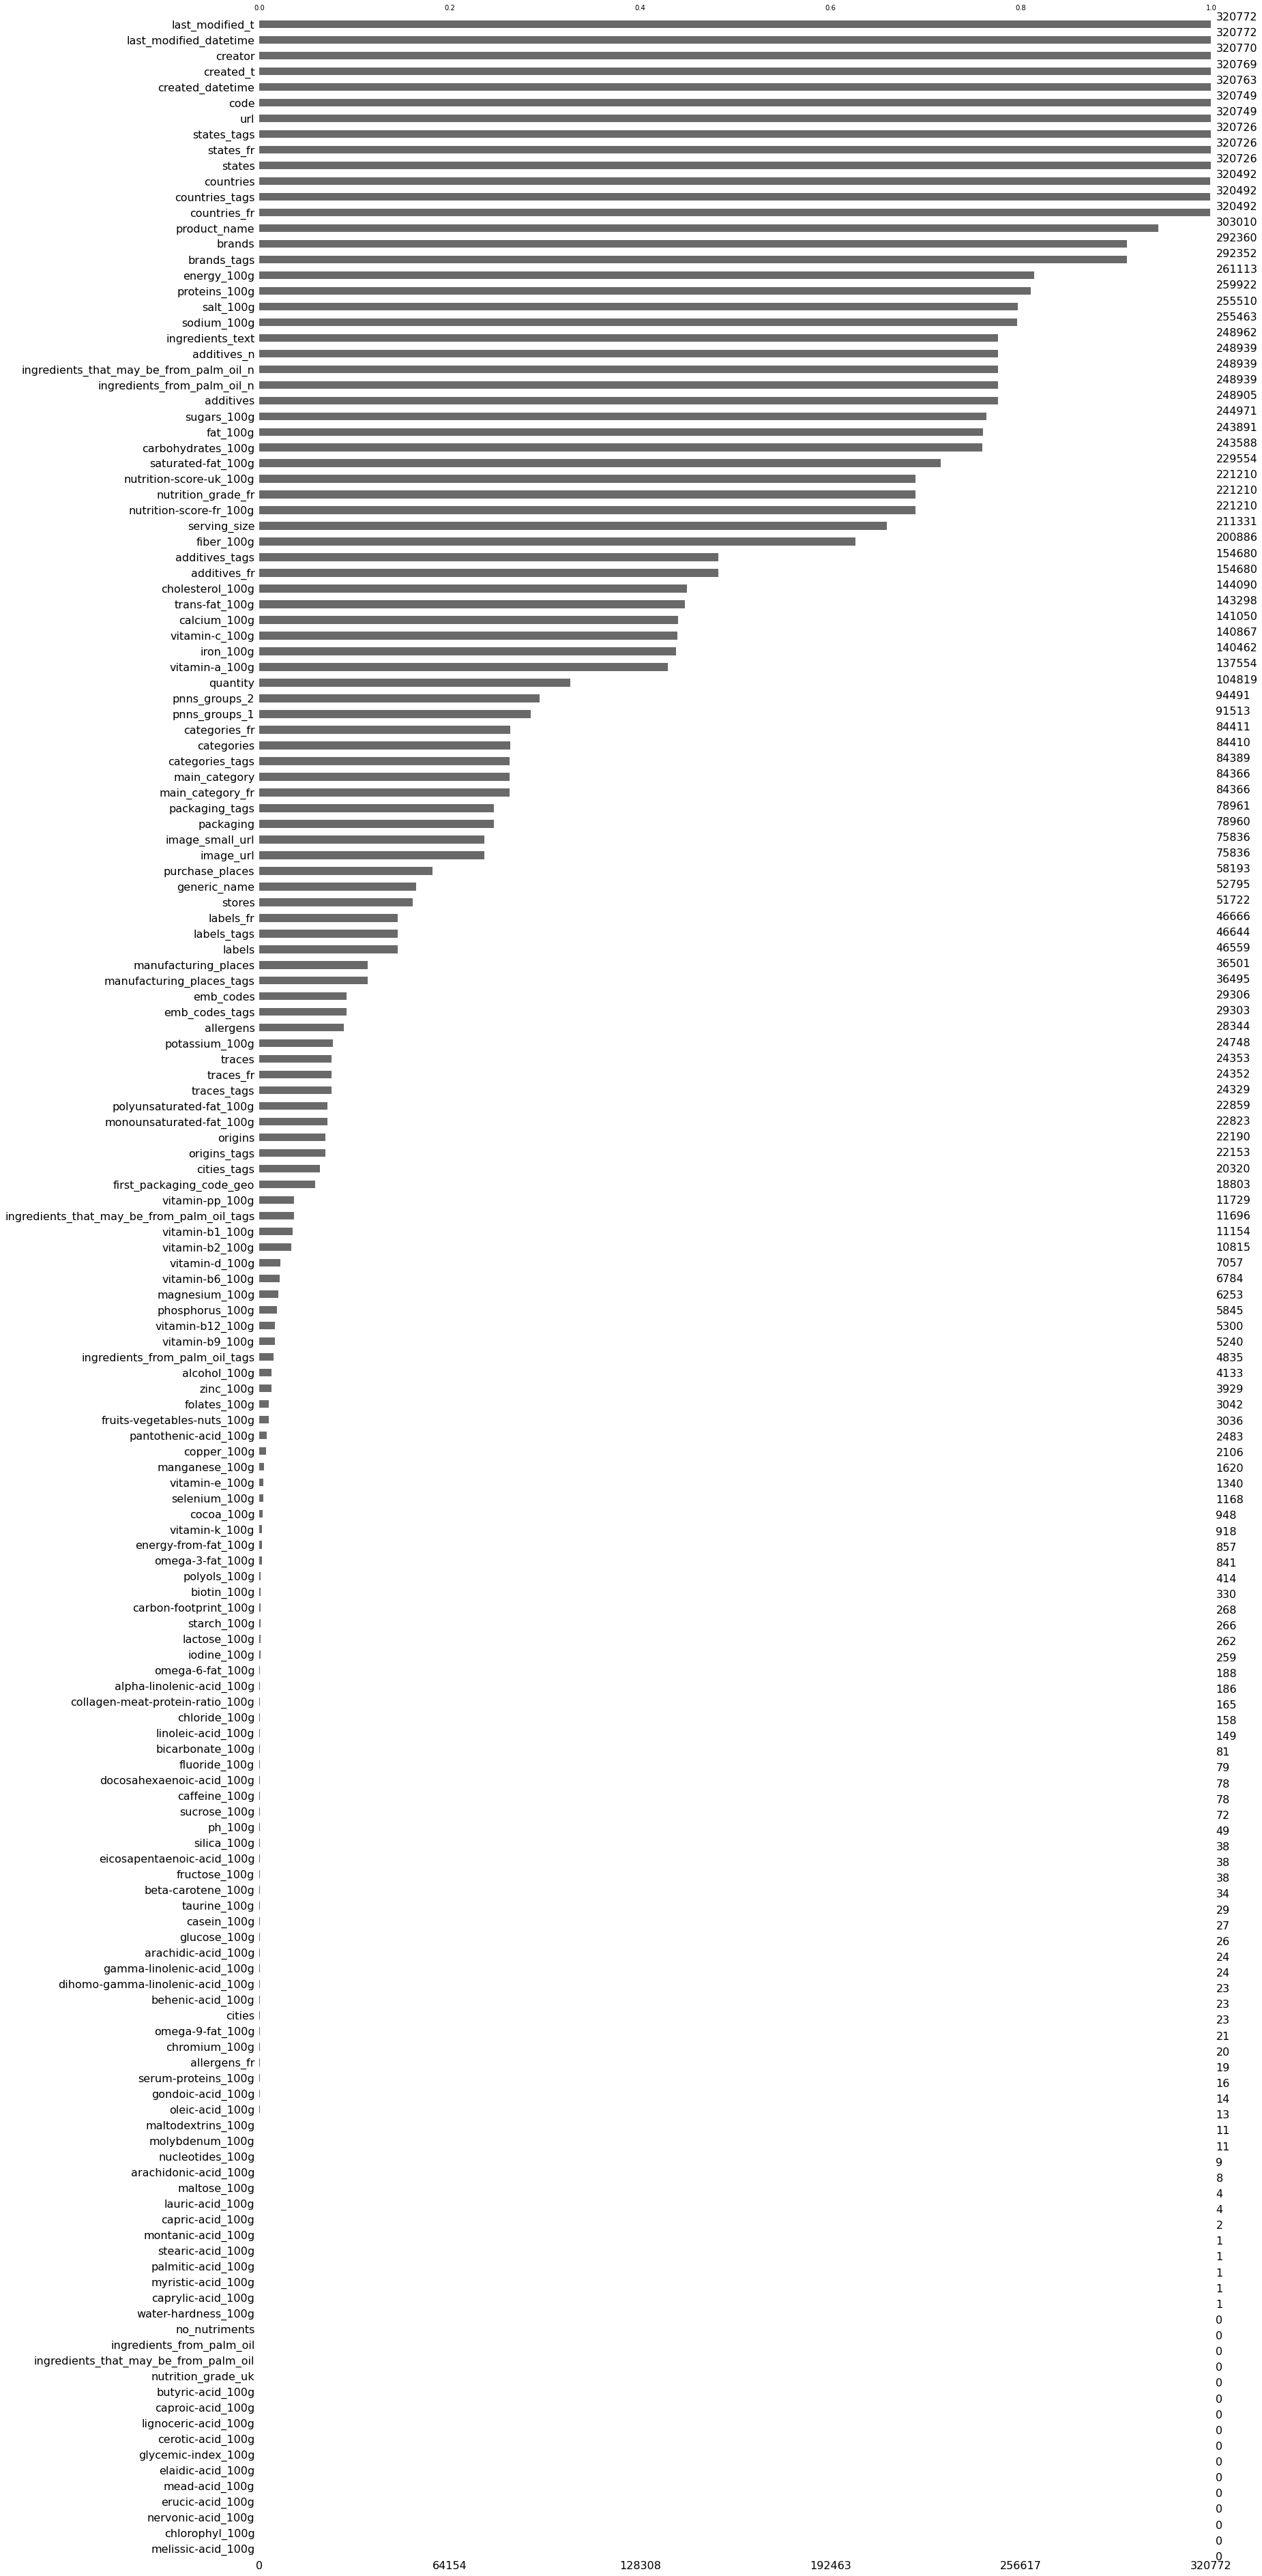

In [22]:
missingno.bar(df, sort='ascending')

Dans le missingno bar plot, nous pouvons remarquer que le dataset est très vide. La première manipulation de nettoyage est de supprimer toutes les variables pour lesquelles il nous manque plus que 80% de valeurs.

In [23]:
limitPer = len(df) * .20
df = df.dropna(thresh=limitPer, axis=1)

A l'aide des box plots pour nos variables numériques selectionnés, nous pouvons vérifier l'existence d'outliers. 

In [24]:
df_num_selected = ['energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']

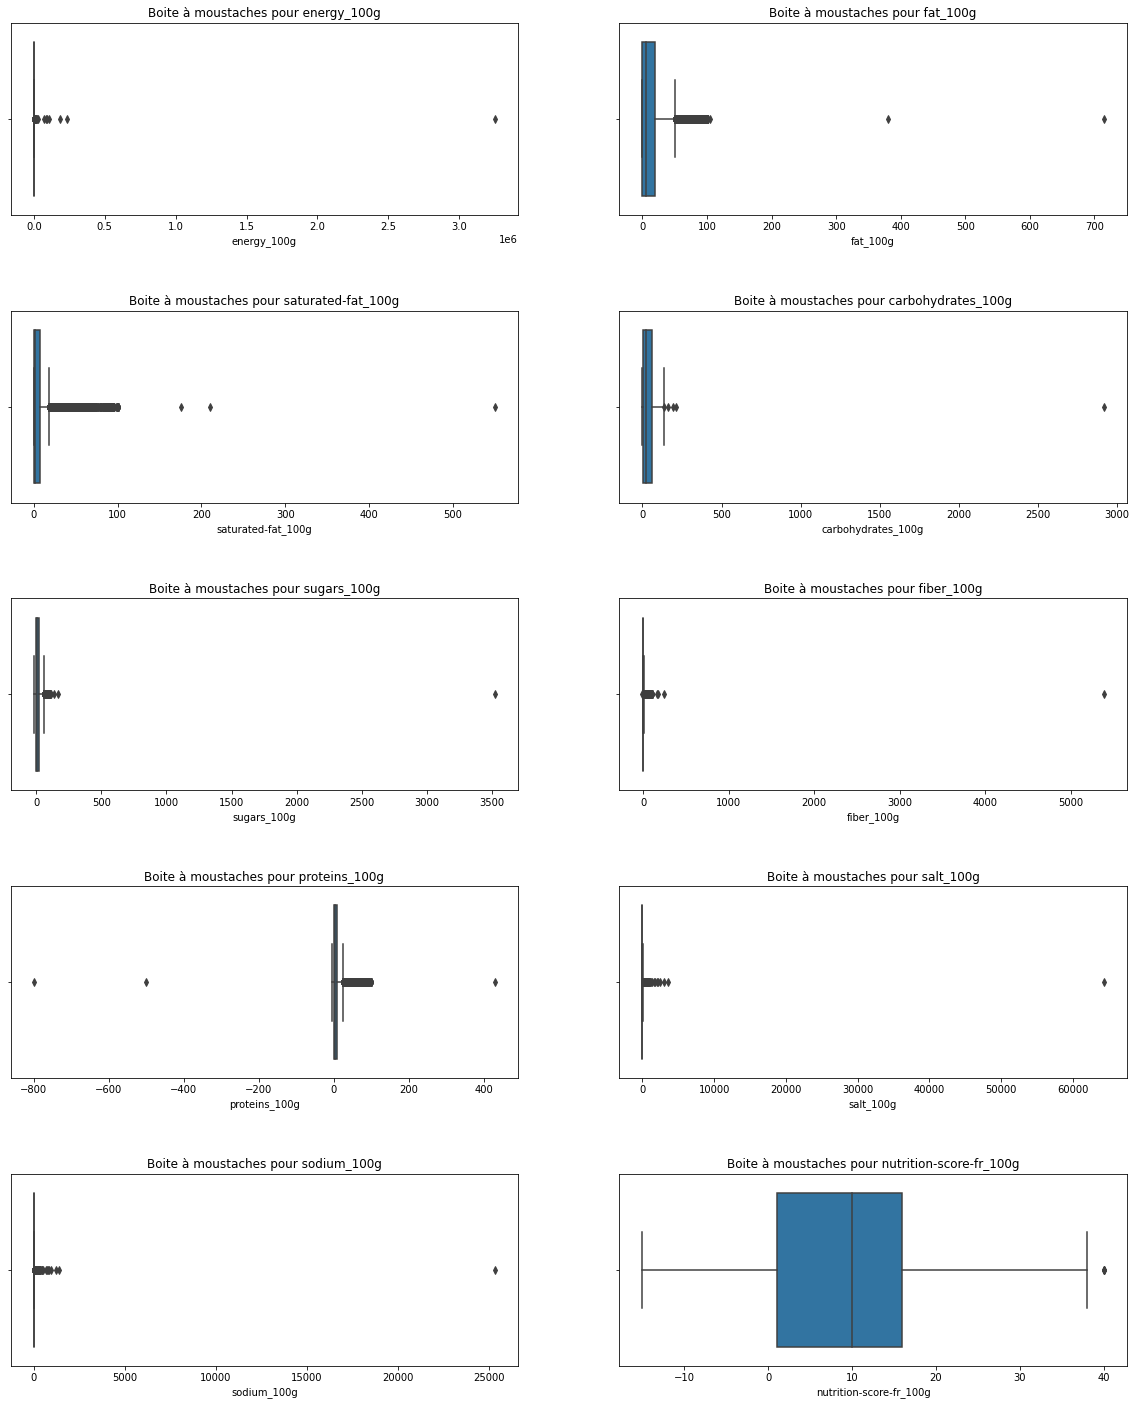

In [25]:
# Box plots

vars = df_num_selected

nbr_rows = int(len(vars)/2) + 1
index = 1
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for column in vars:
    plt.subplot(nbr_rows, 2, index)
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.title(f"Boite à moustaches pour {column}")
    index += 1
plt.show()

Ensuite, nous allons remplacer toutes les valeurs négatives par NaN sauf nutrition-score-fr-100g, qui peut descendre en dessous de 0. Nous allons également remplacer par NaN les valeurs qui dépassent 100g sauf energy_100g qui est calculé en kcal.

In [26]:
# Rassembler les valeurs nutritives (variables qui contiennent le string "100g") 
columns100g = df.columns[df.columns.str.contains(pat = '100g')]

# NaN les valeurs négatives pour toutes les variables sauf nutrition-score-fr-100g qui peut descendre
# en dessous de 0
for column in df:
    if ((column in columns100g)&(column != "nutrition-score-fr_100g")):
        df.loc[df[column]< 0] = np.nan

# NaN toutes les valeurs qui dépassent 100g sauf energy_100g qui est calculé en kcal
for column in df:
    if ((column in columns100g)&(column != "energy_100g")):
        df.loc[df[column] > 100] = np.nan

La prochaine manipulation est de imputer à NaN les outliers de la variable "energy_100g" à l'aide de l'écart interquartile.

In [27]:
# remove outliers from energy_100g

Q1 = df["energy_100g"].quantile(0.25)
Q3 = df["energy_100g"].quantile(0.75)
IQR = Q3 - Q1

upper = Q3+1.5*IQR
lower = Q1+1.5*IQR

# remplacer les valeurs qui dépassent la limite supérieure par NaN

df.loc[df["energy_100g"]>upper,"energy_100g"] = np.nan

Nous supprimons les doublons dans 'code' et 'product_name'.

In [28]:
# Doublons
df = df.drop_duplicates(subset=['product_name', 'code'], keep='last')

In [29]:
print("Nous avons pu réduire la taille de notre dataset de {} variables à {} variables.".format(df_unclean.shape[1], format(df.shape[1])))
print("Nous avons pu réduire la taille de notre dataset de {} individus à {} individus.".format(df_unclean.shape[0], format(df.shape[0])))

Nous avons pu réduire la taille de notre dataset de 162 variables à 54 variables.
Nous avons pu réduire la taille de notre dataset de 320772 individus à 283183 individus.


Nous allons remplir les valeurs manquantes dans : fat_100g, carbohydrates_100g, sugars_100g, salt_100g, sodium_100g via IterativeImputer.

In [30]:
itimp_feats = ['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g']

iter_imputer = IterativeImputer(random_state=0, max_iter=15)
iter_imputed = iter_imputer.fit_transform(df[itimp_feats])
df_iter_imputed = pd.DataFrame(iter_imputed, columns=itimp_feats)

df.update(df_iter_imputed)

Nous allons remplir les valeurs manquantes dans : saturated-fat_100g, fiber_100g et proteins_100g par 0.

In [31]:
tozero_feats = ["saturated-fat_100g", "fiber_100g", "proteins_100g"]
df[tozero_feats] = df[tozero_feats].fillna(0)
df[tozero_feats].isna().sum()

df['fat_100g'] = df['fat_100g'].fillna(0)

Grâce à la fonction definé checkEnergy, nous pouvons comparer la valeur de 'energy_100g' renseigné au résultat de la fonction officielle du nutri-grade (proteines*4 + glucides*4 + fat*9). Si la valeur renseigné diffère trop de la valeur obtenue, nous remplaçons par la valeur de la fonction.

In [32]:
df['energy_100g'].fillna(0, inplace=True)

In [33]:
def checkEnergy(row):
    formula = row['proteins_100g']*4 + row['carbohydrates_100g']*4 + row['fat_100g']*9
    old = row['energy_100g']
    differ = abs(formula - old)
    if (differ > 100):
        row['energy_100g'] = formula
    
    return row

In [34]:
df = df.apply(checkEnergy, axis=1)

La dernière manipulation consiste à imputer les valeurs manquantes de 'nutrition-score-fr_100g'. Nous allons utiliser pour cela les moyennes des nutrition scores de chaque pnns1 groupe, comme vu plus bas. Pour cela, il faut d'abord nettoyer la variable 'pnns_groups_1' et faire en sorte qu'il n'y ait plus de NaN.  

Ensuite, avec les methodes groupby, fillna et transform, nous obtenons une variable 'nutrition-score-fr_100g' sans valeurs manquantes et avec une moyenne inchangée.

In [35]:
df["nutrition-score-fr_100g"].isna().sum()

99418

In [36]:
df['pnns_groups_1'] = df['pnns_groups_1'].replace('-',' ',regex=True)
df['pnns_groups_1'] = df['pnns_groups_1'].str.lower()
df['pnns_groups_2'] = df['pnns_groups_2'].str.lower() # en passant nous allons aussi nettoyer les variables de pnns_groups_2...
df['pnns_groups_1'].fillna('unknown', inplace=True)

In [37]:
pnns_score_means = df.groupby(["pnns_groups_1"]).mean()
pnns_score_means['nutrition-score-fr_100g'].sort_values(ascending=True)

pnns_groups_1
fruits and vegetables       3.256390
composite foods             5.274254
cereals and potatoes        7.004458
milk and dairy products     9.159248
beverages                  10.181573
fish meat eggs             10.797594
unknown                    11.712855
fat and sauces             12.553385
salty snacks               13.197220
sugary snacks              17.927895
Name: nutrition-score-fr_100g, dtype: float64

In [38]:
df['nutrition-score-fr_100g'] = df['nutrition-score-fr_100g'].fillna(df.groupby("pnns_groups_1")['nutrition-score-fr_100g'].transform("mean"))

In [39]:
pnns_score_means = df.groupby(["pnns_groups_1"]).mean()
pnns_score_means['nutrition-score-fr_100g'].sort_values(ascending=True)

pnns_groups_1
fruits and vegetables       3.256390
composite foods             5.274254
cereals and potatoes        7.004458
milk and dairy products     9.159248
beverages                  10.181573
fish meat eggs             10.797594
unknown                    11.712855
fat and sauces             12.553385
salty snacks               13.197220
sugary snacks              17.927895
Name: nutrition-score-fr_100g, dtype: float64

Les nutrition-score moyens de chaque groupe pnns n'ont pas changé. C'est le nettoyage le plus précis qu'on aurait pu faire avec la quantité de données que nous avons.

In [40]:
df[df_num_selected].fillna(0, inplace=True)
df["carbohydrates_100g"].fillna(0, inplace=True)
df["sugars_100g"].fillna(0, inplace=True)
df["salt_100g"].fillna(0, inplace=True)
df["sodium_100g"].fillna(0, inplace=True)

<AxesSubplot:>

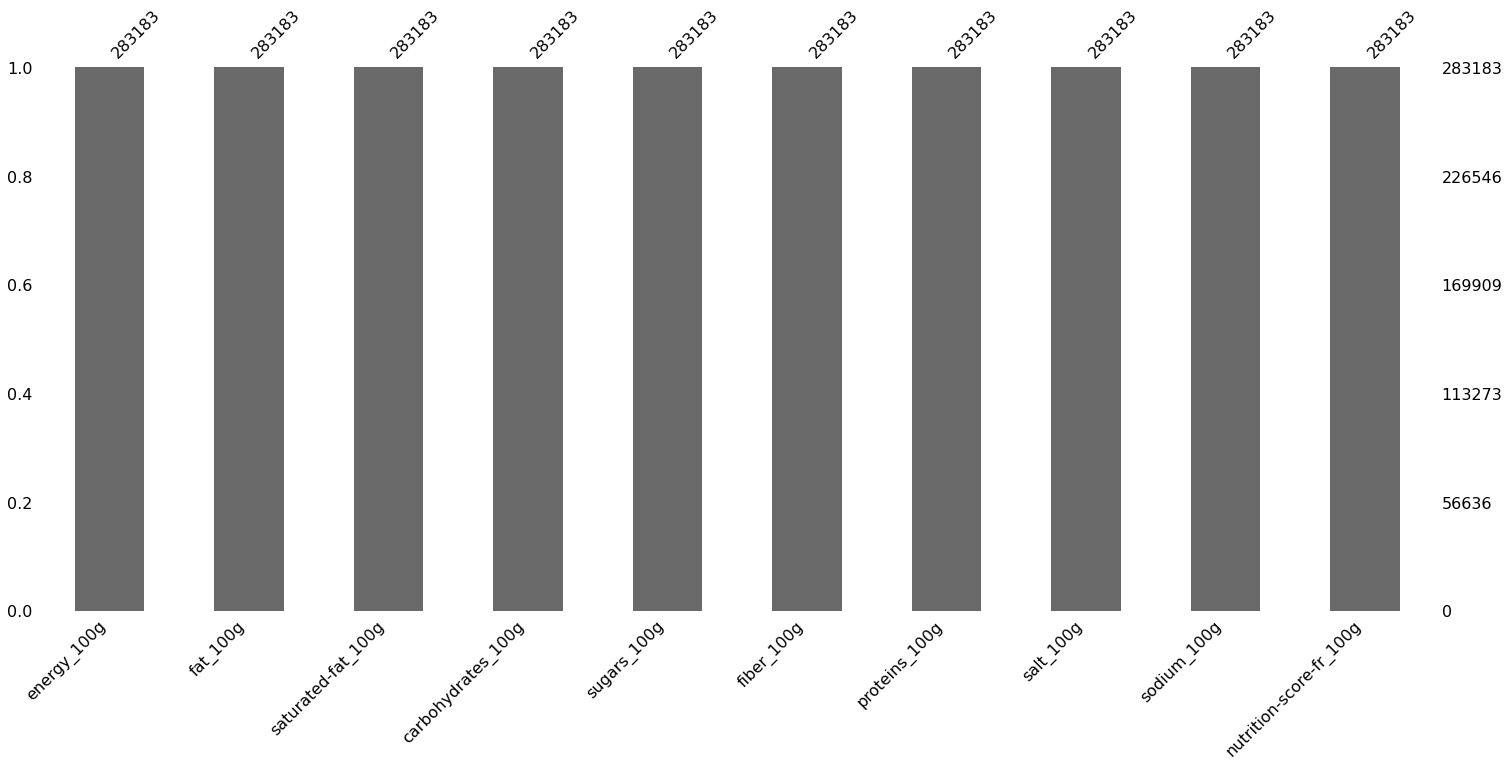

In [41]:
missingno.bar(df[df_num_selected])

### Nettoyage des variables qualitatives

In [42]:
df_cat_selected = ['product_name', 'categories', 'categories_tags', 'categories_fr', 'nutrition_grade_fr', 
                     'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr']

In [43]:
df = df[df_cat_selected + df_num_selected]

<AxesSubplot:>

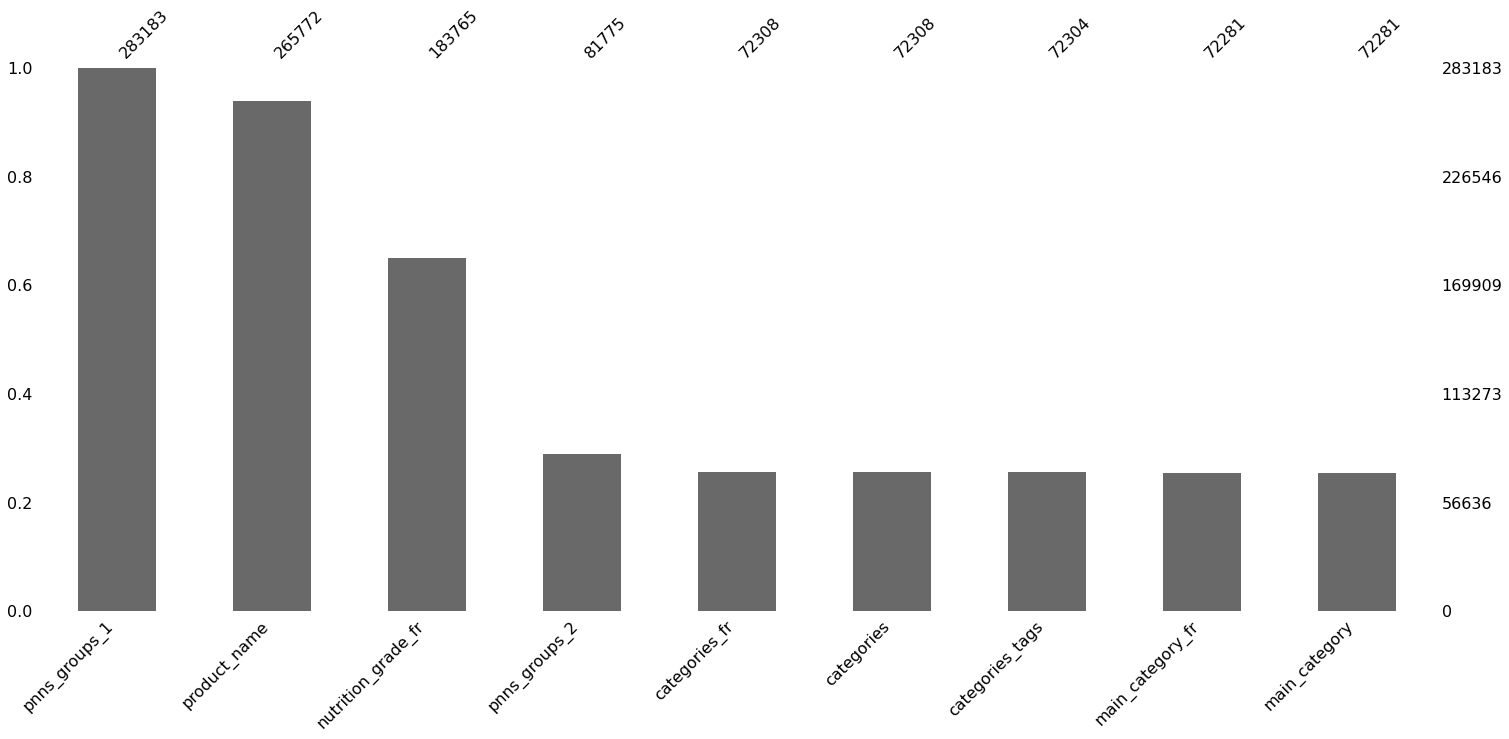

In [44]:
missingno.bar(df[df_cat_selected], sort="descending")

In [45]:
df[df_cat_selected].isna().sum()

product_name           17411
categories            210875
categories_tags       210879
categories_fr         210875
nutrition_grade_fr     99418
pnns_groups_1              0
pnns_groups_2         201408
main_category         210902
main_category_fr      210902
dtype: int64

Comme nous pouvons constater ci-bas, il existe des colonnes qui sont presque vides à part le nom du produit...ces colonnes ne sont pas exploitables car nous n'avons pas la possibilité de remplir les variables.

In [46]:
df[df_cat_selected].head(20)

,product_name,categories,categories_tags,categories_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,main_category_fr
0,Farine de blé noir,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),NaN,NaN,NaN,d,unknown,NaN,NaN,NaN
2,Peanuts,NaN,NaN,NaN,b,unknown,NaN,NaN,NaN
3,Organic Salted Nut Mix,NaN,NaN,NaN,d,unknown,NaN,NaN,NaN
4,Organic Polenta,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN
5,Breadshop Honey Gone Nuts Granola,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN
6,Organic Long Grain White Rice,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN
7,Organic Muesli,NaN,NaN,NaN,c,unknown,NaN,NaN,NaN
8,Organic Dark Chocolate Minis,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN
9,Organic Sunflower Oil,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN


Dans notre dataframe de variables categorielles, il existe beaucoup de lignes qui sont presque vides, à part le nom du produit et parfois peut-être le nutrition-grade. Nous ne pouvons pas vraiment exploiter ces lignes dont nous allons garder que les lignes pour lesquels nous avons au moins 5 valeurs dans les colonnes.

In [47]:
ind_before = df.shape[0]
var_before = df.shape[1]

In [48]:
df.dropna(subset=df_cat_selected, thresh=5, inplace=True)

In [49]:
diff_ind = ind_before - df.shape[0]

Nous avons supprimé tous les individus pour lesquels il manque des données dans au moins 5 colonnes afin que le jeu de données devienne exploitable.

In [50]:
print("Le jeu de données a été réduite de {} individus.".format(diff_ind))

Le jeu de données a été réduite de 210879 individus.


<AxesSubplot:>

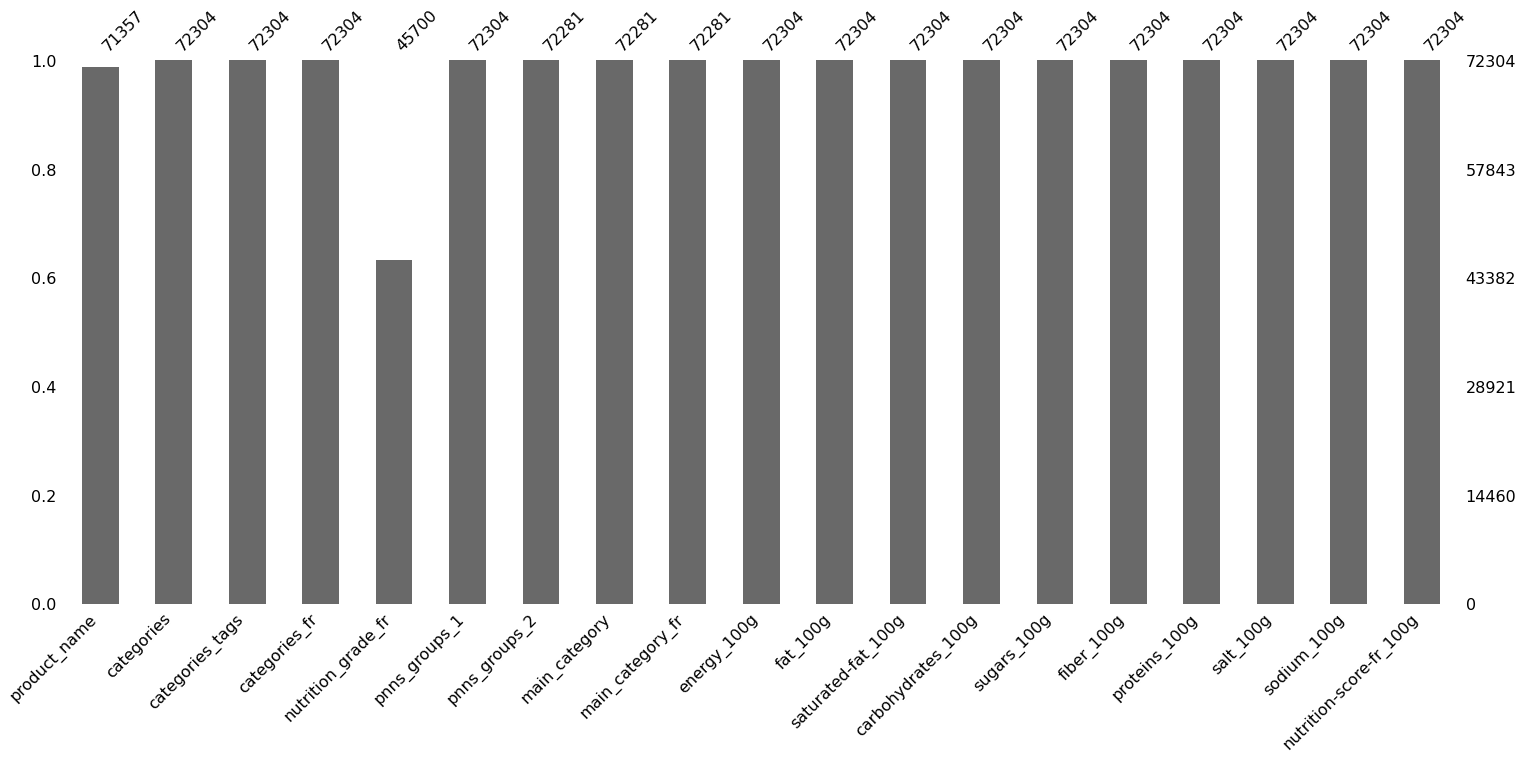

In [51]:
missingno.bar(df)

#### Nettoyage de nutrition grade : remplissage des valeurs manquantes

Avec la fonction groupby, nous pouvons constater des différentes moyennes de nutrition-score-fr.  

Ces moyennes corréspondent à un nutri-grade de 'C' ou de 'D'.  

In [52]:
pnns_score_means = df.groupby(["pnns_groups_1"]).mean()
pnns_score_means['nutrition-score-fr_100g'].sort_values(ascending=True)

pnns_groups_1
fruits and vegetables       3.256390
composite foods             5.274254
cereals and potatoes        7.004458
milk and dairy products     9.159248
beverages                  10.181573
fish meat eggs             10.797594
unknown                    11.329649
fat and sauces             12.553385
salty snacks               13.197220
sugary snacks              17.927895
Name: nutrition-score-fr_100g, dtype: float64

Nous allons remplacer les nutri-grade NaN avec 'C' pour les catégories pnns1 suivantes : 
* 'fruits and vegetables'
* 'composite foods'
* 'cereals and potatoes'
* 'milk and dairy products'
* 'fish meat eggs'

Et avec 'D' pour :
* 'beverages' 
* 'unknown'
* 'fat and sauces'
* 'salty snacks'
* 'sugary snacks'

In [53]:
df["product_name"].fillna("unknown", inplace=True)

In [54]:
nutriscoreC = df[df["pnns_groups_1"]==(("fruits and vegetables")or("composite foods")or("cereals and potatoes")or("milk and dairy products")or("fish meat eggs"))]
nutriscoreC["nutrition_grade_fr"].fillna('c', inplace=True)
df.update(nutriscoreC)

In [55]:
df["nutrition_grade_fr"].fillna('d', inplace=True)

<AxesSubplot:>

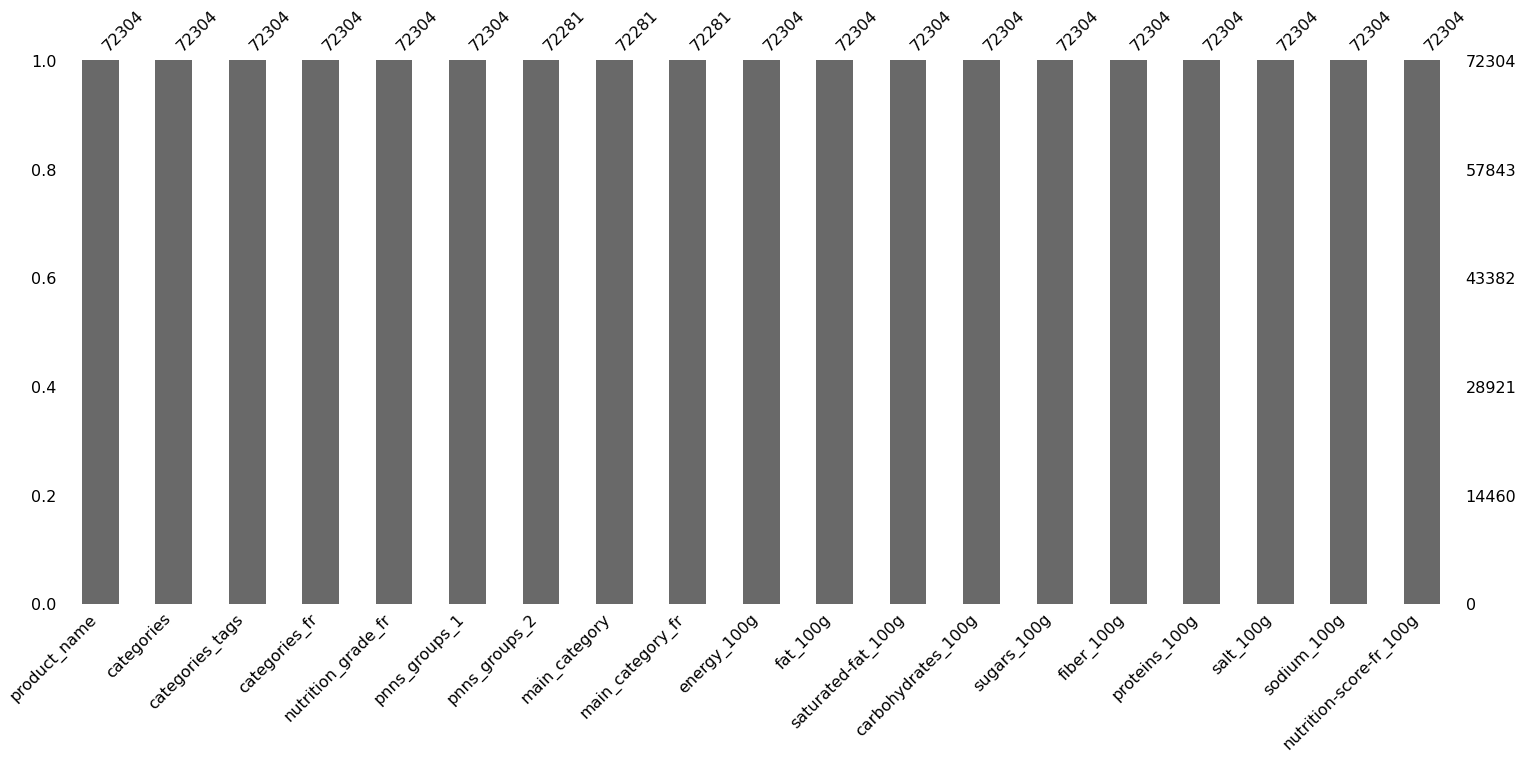

In [56]:
missingno.bar(df)

In [57]:
# Un dernier nettoyage avant d'exporter notre jeu de données :

df['nutrition_grade_fr'] = df['nutrition_grade_fr'].str.upper()
df = df.drop(['categories_tags', 'categories_fr', 'main_category', 'main_category_fr'], axis=1)

df.drop(df.index[df['pnns_groups_1'] == 'unknown'], inplace=True)
df.drop(df.index[df['pnns_groups_2'] == 'unknown'], inplace=True)

In [58]:
df_unclean.shape

(320772, 162)

In [59]:
df.shape

(57819, 15)

Avant nettoyage, le jeu de données comptait 320772 individus pour 162 variables.  
Après néttoyage, il compte 57819 individus et 15 variables.

In [60]:
df.to_csv('openfood_filtered.csv')

## 2 - Analyse des données

##### Aide au choix d'un produit
Un exemple d'une implementation de ces données est une application d'aide au choix d'un produit. Pour cela, il est important de comprendre comment le nutri-grade d'un produit est impacté par les composants de l'aliment (carbohydrates, sodium, graisses, etc).  

### Analyse univariée variables qualitatives

A l'aide d'un countplot, nous constatons que les aliments de nutrition grade 'D' sont les plus nombreux. Les aliments de nutrition grade 'A' sont si peu nombreux qu'ils ne sont pas visibles.

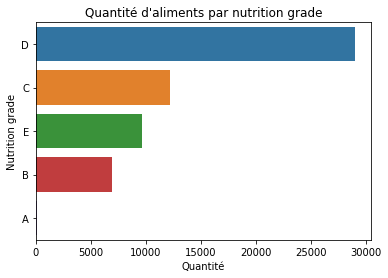

In [61]:
# Aliments par nutrition grade

foods_count = df['nutrition_grade_fr'].value_counts().index
sns.countplot(y="nutrition_grade_fr", order=foods_count, data=df);
plt.title("Quantité d'aliments par nutrition grade")
plt.xlabel("Quantité")
plt.ylabel("Nutrition grade")
plt.show()

In [62]:
df.groupby(['nutrition_grade_fr']).mean()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
nutrition_grade_fr,,,,,,,,,,
A,226.573156,12.741706,0.121127,27.642353,15.701677,0.215493,0.987324,1.013506,0.399018,1.098592
B,271.411056,14.019795,1.180133,29.345584,14.477288,1.243301,6.252232,1.443903,0.568463,0.936213
C,262.312185,13.523713,2.144658,28.374453,14.444551,1.441509,6.030661,1.440043,0.566945,5.233239
D,271.214622,14.688695,3.954773,29.106658,15.096539,0.727749,5.396726,1.482652,0.583720,12.419522
E,313.564412,16.683606,13.029727,33.096045,19.257550,1.015997,6.732465,1.516051,0.596877,21.123665


L'information dans le tableau groupby() est interessante car elle nous informe qu'avec le nutrition grade qui passe de A a E, nous voyons l'energie, les graisses, les graisses saturés, les glucides et les sucres. Bien evidemment le nutrition score augmente aussi.  

Nous pouvons vérifier ce phénomène avec l'ACP et l'ANOVA plus bas.

Nous nous interessons également à la répartition des aliments par catégorie (PNNS 1) et sous-catégorie (PNNS 2), visualisé à l'aide d'un histogramme.

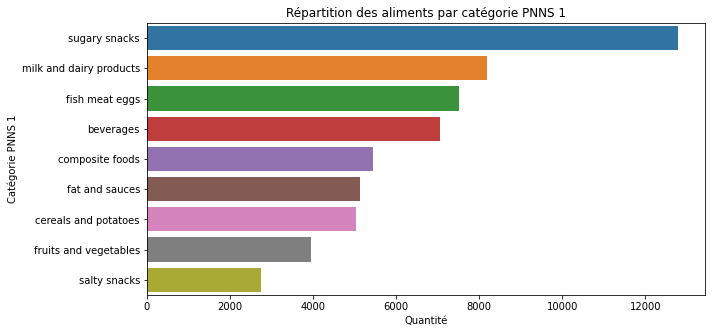

In [63]:
# Aliments par pnns1

plt.figure(figsize=(10, 5))
foods_count = df['pnns_groups_1'].value_counts().index
sns.countplot(y='pnns_groups_1', order=foods_count, data=df);
plt.title("Répartition des aliments par catégorie PNNS 1")
plt.xlabel("Quantité")
plt.ylabel("Catégorie PNNS 1")
plt.show()

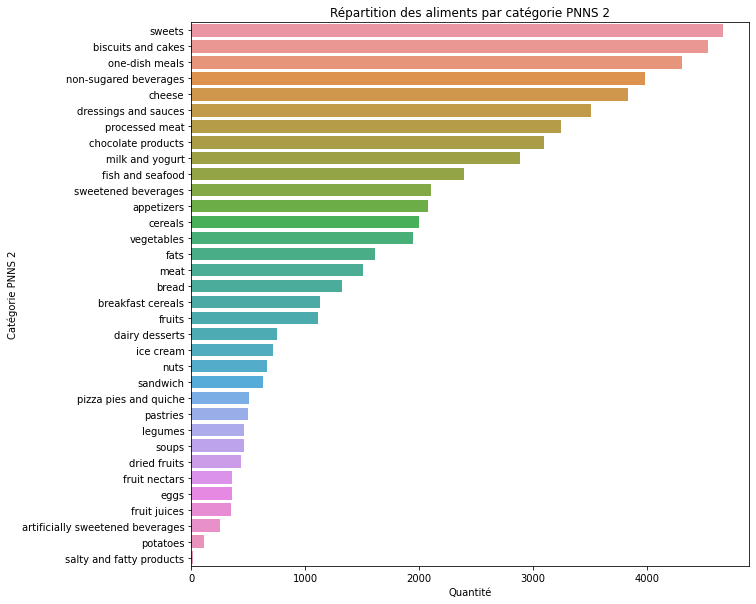

In [64]:
# Aliments par pnns2

plt.figure(figsize=(10, 10))
foods_count = df['pnns_groups_2'].value_counts().index
sns.countplot(y='pnns_groups_2', order=foods_count, data=df);
plt.title("Répartition des aliments par catégorie PNNS 2")
plt.xlabel("Quantité")
plt.ylabel("Catégorie PNNS 2")
plt.show()

### Analyse bivariée variables qualitatives

In [65]:
# nutri-grade et categorie d'aliment
import plotly.express as px
fig = px.histogram(df, x='pnns_groups_1', color='nutrition_grade_fr', 
        title = 'Répartition des aliments en fonction de leur nutrition grade et catégorie')

fig.show()

### Analyse univariée variables quantitatives

Les boîtes à moustaches suivantes nous permettent de vérifier qu'il n'y ait plus d'outliers dans nos variables.

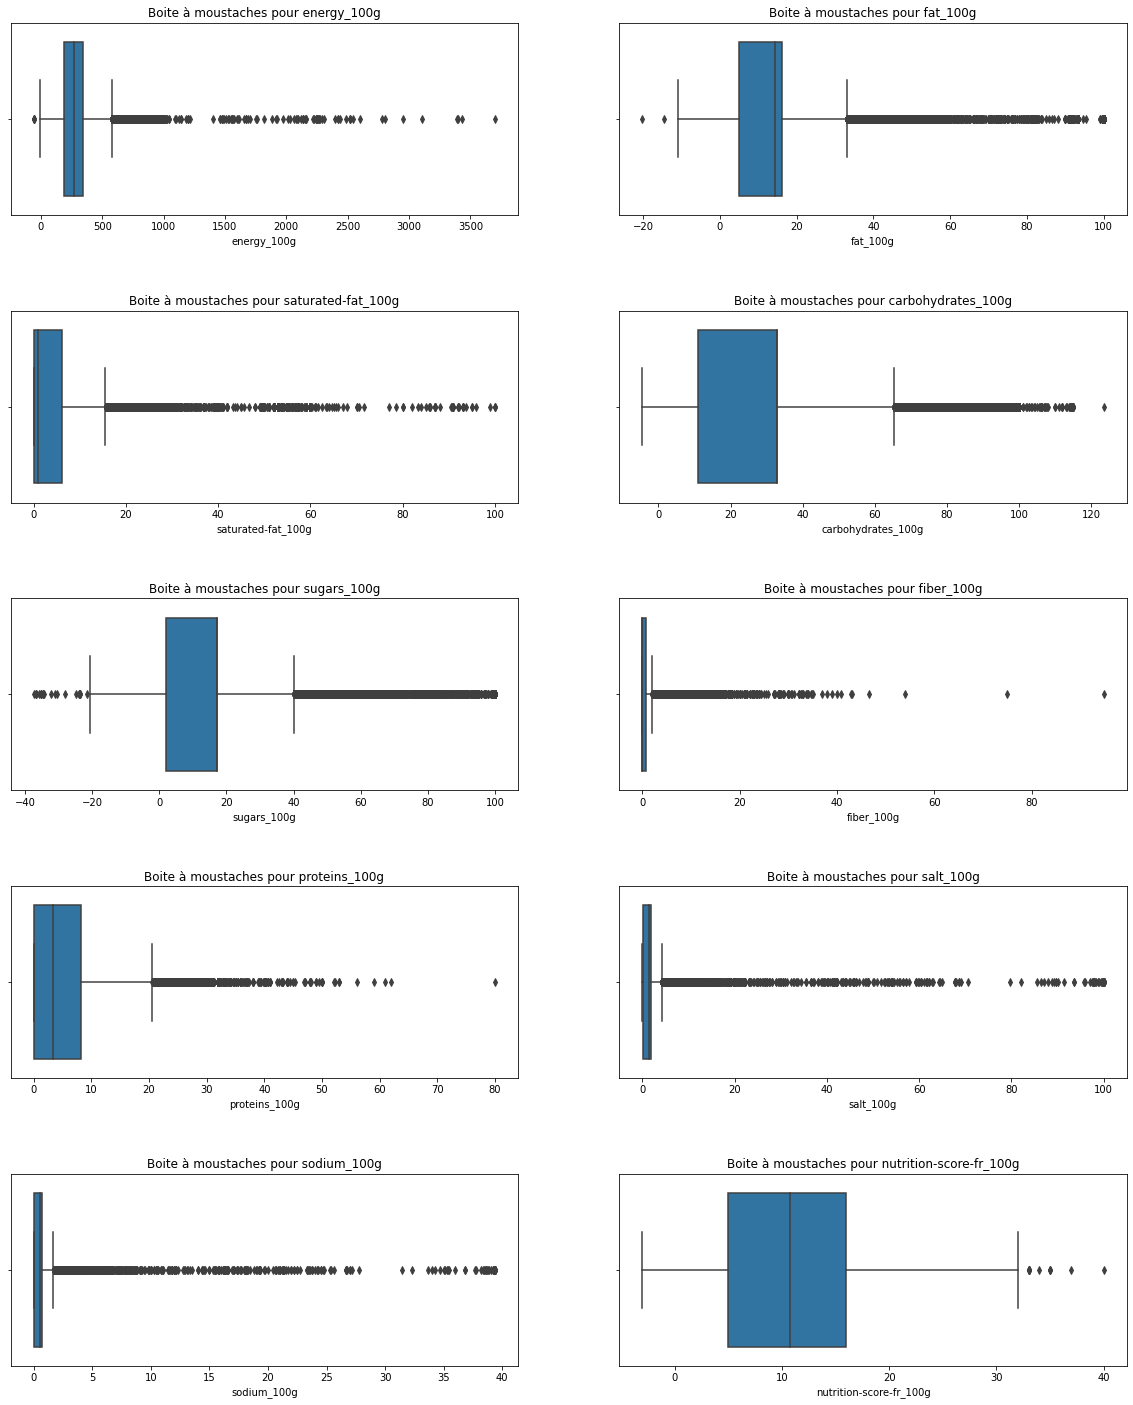

In [66]:
# Box plots

vars = df_num_selected

nbr_rows = int(len(vars)/2) + 1
index = 1
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for column in vars:
    plt.subplot(nbr_rows, 2, index)
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.title(f"Boite à moustaches pour {column}")
    index += 1
plt.show()

### Analyse multivariée variables quantitatives

La correlation entre les variables numériques est essentielle à notre analyse car elle permet de vérifier la rélation entre chaque variable, information que nous allons voir avec plus de précision avec l'ACP et l'ANOVA.

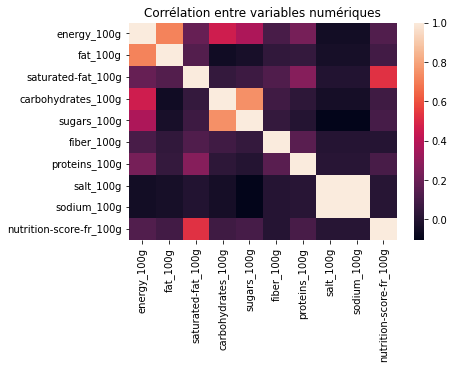

In [67]:
# Correlation entre 100g

sns.heatmap(df[df_num_selected].corr())
plt.title("Corrélation entre variables numériques")
plt.show()

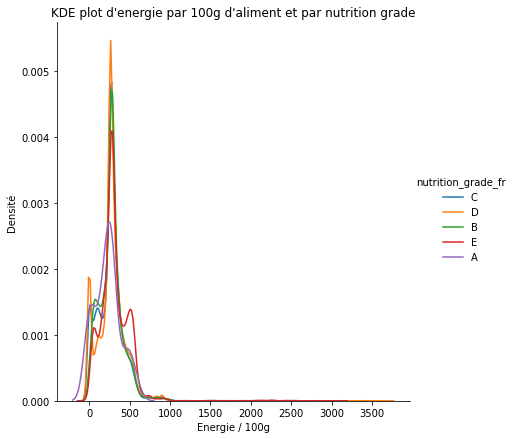

In [68]:
sns.FacetGrid(df, hue="nutrition_grade_fr", height=6).map(sns.kdeplot, "energy_100g").add_legend()
plt.title("KDE plot d'energie par 100g d'aliment et par nutrition grade")
plt.xlabel("Energie / 100g")
plt.ylabel("Densité")
plt.show()

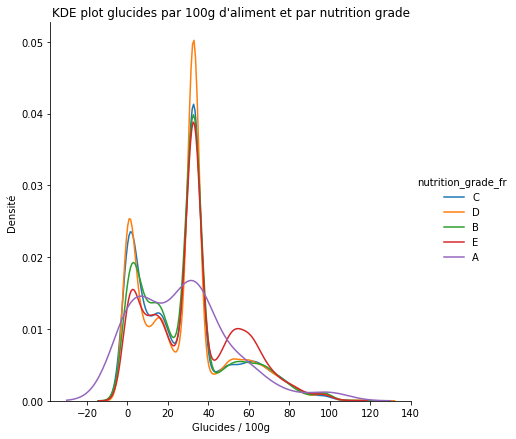

In [69]:
sns.FacetGrid(df, hue="nutrition_grade_fr", height=6).map(sns.kdeplot, "carbohydrates_100g").add_legend()
plt.title("KDE plot glucides par 100g d'aliment et par nutrition grade")
plt.xlabel("Glucides / 100g")
plt.ylabel("Densité")
plt.show()

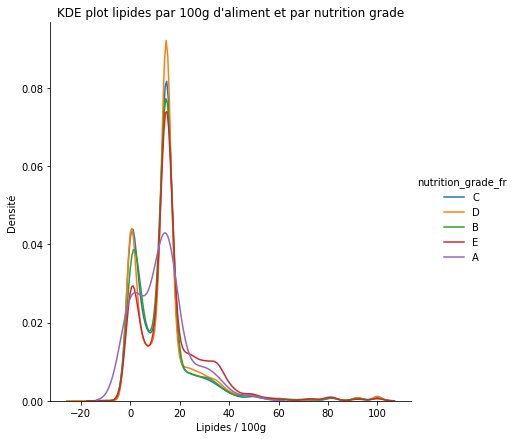

In [70]:
sns.FacetGrid(df, hue="nutrition_grade_fr", height=6).map(sns.kdeplot, "fat_100g").add_legend()
plt.title("KDE plot lipides par 100g d'aliment et par nutrition grade")
plt.xlabel("Lipides / 100g")
plt.ylabel("Densité")
plt.show()

## Principal Component Analysis

In [71]:
df_num_selected

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

In [72]:
acp_selected = ['energy_100g',
 'fat_100g',
 'carbohydrates_100g',
 'fiber_100g',
 'proteins_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

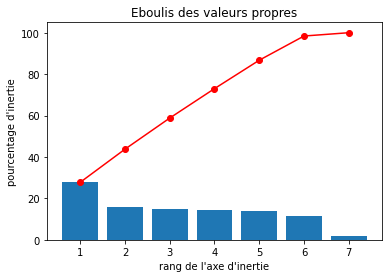

In [73]:
# Eboulis des valeurs propres

acp_vars = acp_selected
X = df[acp_vars].dropna()
keep_ind = X.index
X = StandardScaler().fit_transform(X)

pca = decomposition.PCA(n_components=len(acp_vars))
pca.fit(X)
X = pca.transform(X)

functions.display_scree_plot(pca)

Nous allons garder les 6 premiers rangs de l'axe d'inértie pour la suite de l'ACP.

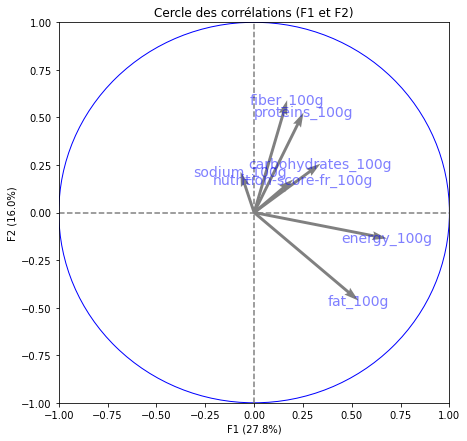

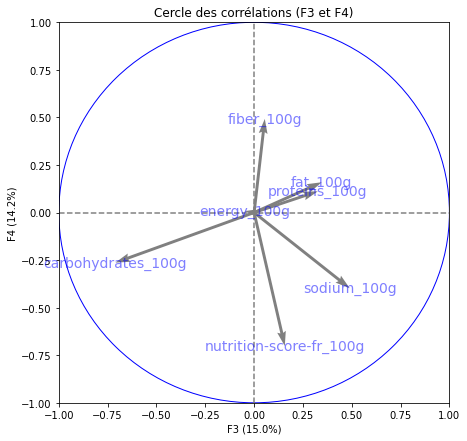

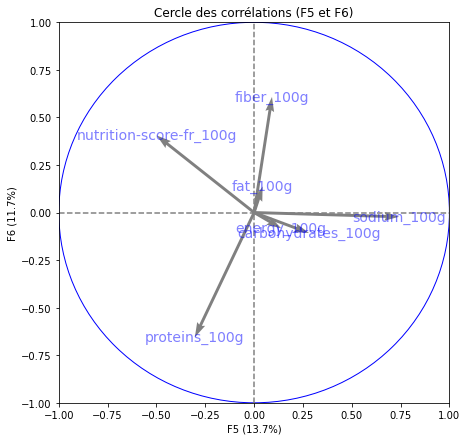

In [74]:
# Cercle des corrélations (F1 & F2) , (F3 & F4) , (F5 & F6)
from functions import *
pcs = pca.components_
functions.display_circles(pcs, 6, pca, [(0,1),(2,3),(4,5)], labels = np.array(acp_vars))

Les informations concernant les composantes selon les cercles de corrélation :  

* Composante F1 : les fibres et les protéines sont corrélées, l’énergie et les graisses sont corrélées, + de fibres, protéines, énergie et lipides, moins de sodium
* Composante F2 : plus de fibres et protéines ou sodium = moins d’énergie ou lipides
* Composante F3 : plus de lipides, de sodium ou un nutrition score élevé (moins sain), moins de fibre/carbohydrates
* Composante F4 : un nutrition score élevé = plus de carbohydrates, plus de sodium, moins de fibres et de lipides
* Composante F5 : plus de sodium = moins de protéines, nutrition-score moins élevé, moins de protéines
* Composante F6 : plus de fibres et un nutrition score plus élevé, moins de protéines


Les hypothèses que nous pouvons tirer de l'ACP sont donc que :  

* Plus d'énergie = plus de lipides
* Plus de fibres = plus de protéines
* Le sel, le nutrition score et les glucides sont positivement corrélées
* Le nutrition score et les protéines sont négativement corrélées  

D'après l'ACP, ce qui rend un aliment plus sain est donc la présence de protéines et de fibres. Ce qui rend un aliment moins sain est la présence de glucides, de sel et très légèrement de lipides.  

## ANOVA

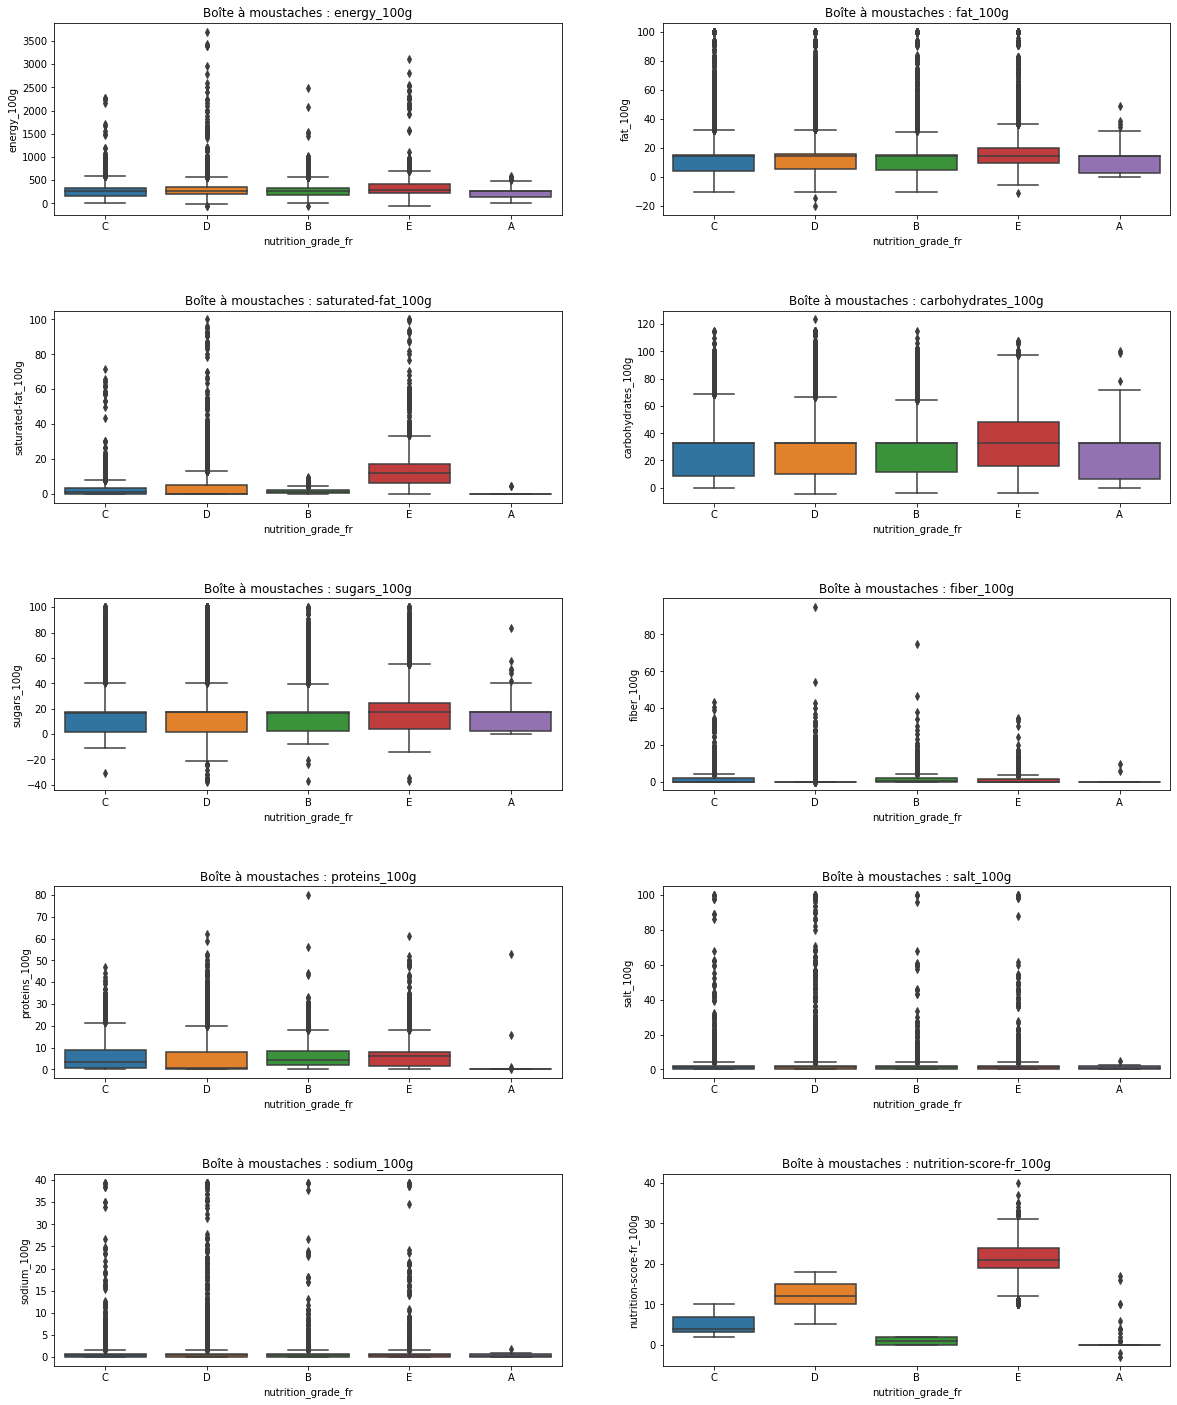

In [75]:
vars = df_num_selected

nbr_rows = int(len(vars)/2) + 1
index = 1
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for column in vars:
    
    plt.subplot(nbr_rows, 2, index)
    ax = sns.boxplot(x="nutrition_grade_fr", y=column, data=df)
    plt.xlabel('nutrition_grade_fr')
    plt.ylabel(column)
    plt.title('Boîte à moustaches : ' + column)
    index += 1

plt.show()

In [76]:
num_fisher = ['energy_100g','fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g']

In [77]:
l = []
for i in range (len(num_fisher)):
    col = num_fisher[i]
    anova_variete = smf.ols('{}~nutrition_grade_fr'.format(col), data=df).fit()
    f_table = sm.stats.anova_lm(anova_variete, typ=2)
    f_value = f_table.loc['nutrition_grade_fr']['PR(>F)']
    l.append(f_value)

In [78]:
d = {'Variable': num_fisher, 'PR(>F)': l}
fisher_df = pd.DataFrame(data=d)
fisher_df

,Variable,PR(>F)
0,energy_100g,2.812085e-123
1,fat_100g,1.433222e-62
2,carbohydrates_100g,2.615459e-62
3,sugars_100g,8.623555e-125
4,fiber_100g,3.804897e-173
5,proteins_100g,4.179073e-66
6,salt_100g,4.533825e-01
7,sodium_100g,4.532234e-01


Conclusion de l’ANOVA :  

* Variables non-corrélées à nutrition_grade_fr (p-value > 5%) : 
salt_100g, sodium_100g
* Variables légèrement corrélées à nutrition_grade_fr (p-value < 5%) : 
fat_100g, carbohydrates_100g, sugars_100g, proteins_100g
* Variables fortement corrélées à nutrition_grade_fr (p-value << 5%) : 
energy_100g, fiber_100g


## Protoype

In [79]:
#cd .\Formation_IA\P3
#python -m voila .\notebook_openfood.ipynb